In [1]:
import jax.numpy as jnp
from jax import random, vmap
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import numpyro
from numpyro.diagnostics import hpdi
import numpyro.distributions as dist
from numpyro import handlers
from numpyro.infer import MCMC, NUTS
from numpyro.infer import Predictive
plt.style.use('bmh')
#numpyro.set_platform("cpu")
numpyro.set_platform("gpu")

/home/kawahara/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [1]:
import numpy as np

この例では、phaseとノイズレベルsigmaを推定します。観測値はy=sin(x + phase)です。

In [2]:
np.random.seed(32)
phase=0.5
sigin=0.3
N=20
x=np.sort(np.random.rand(N))*4*np.pi
y=np.sin(x+phase)+np.random.normal(0,sigin,size=N)

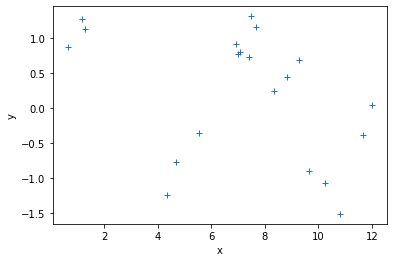

In [4]:
import matplotlib.pyplot as plt
plt.plot(x,y,"+",color="C0")
plt.xlabel("x")
plt.ylabel("y")
plt.savefig("hmc1.pdf")

In [5]:
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist

def model(x,y):
    phase = numpyro.sample('phase', dist.Uniform(-1.0*jnp.pi, 1.0*jnp.pi))
    sigma = numpyro.sample('sigma', dist.Exponential(1.))
    mu=jnp.sin(x+phase)
    numpyro.sample('y', dist.Normal(mu, sigma), obs=y)

In [7]:
from jax import random
from numpyro.infer import MCMC, NUTS

# Start from this source of randomness. We will split keys for subsequent operations.
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)
num_warmup, num_samples = 1000, 2000
# Run NUTS.
kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup, num_samples)
mcmc.run(rng_key_, x=x, y=y)
mcmc.print_summary()

sample: 100%|██████████| 3000/3000 [00:04<00:00, 676.57it/s, 3 steps of size 7.27e-01. acc. prob=0.93]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     phase      0.34      0.12      0.34      0.15      0.56   1363.51      1.00
     sigma      0.34      0.06      0.33      0.24      0.42   1206.21      1.00

Number of divergences: 0


In [13]:
samples = mcmc.get_samples()
samples["phase"]

DeviceArray([0.3120887 , 0.32569715, 0.33308244, ..., 0.26285714,
             0.27468482, 0.36177567], dtype=float32)

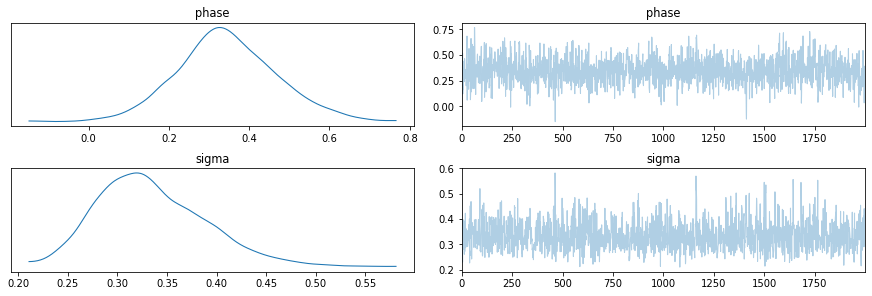

In [14]:
import arviz
arviz.plot_trace(mcmc, var_names=["phase","sigma"])
plt.savefig("hmc2.pdf")

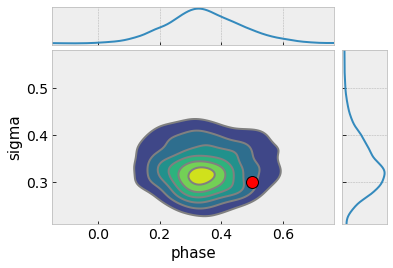

In [34]:
refs={};refs["sigma"]=sigin;refs["phase"]=phase
arviz.plot_pair(arviz.from_numpyro(mcmc),kind='kde',
    divergences=False,marginals=True,reference_values=refs,
    reference_values_kwargs={'color':"red", "marker":"o", "markersize":12}) 
plt.savefig("hmc3.pdf", bbox_inches="tight", pad_inches=0.0)

In [20]:
posterior_phase = mcmc.get_samples()['phase']
posterior_sigma = mcmc.get_samples()['sigma']

In [21]:
from numpyro.infer import Predictive
pred = Predictive(model,{'phase':posterior_phase,'sigma':posterior_sigma},return_sites=["y"])
x_ = jnp.linspace(0,4*jnp.pi,1000)
predictions = pred(rng_key_,x=x_,y=None)

In [27]:
from numpyro.diagnostics import hpdi
mean_muy = jnp.mean(predictions["y"], axis=0)
hpdi_muy = hpdi(predictions["y"], 0.9)

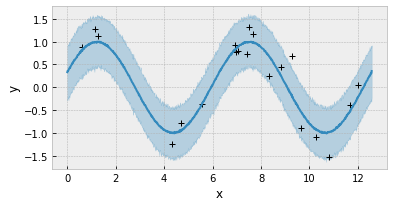

In [33]:
import seaborn as sns
plt.style.use('bmh')

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 3))
ax.plot(x,y,"+",color="black")
ax.plot(x_,mean_muy,color="C0")
ax.fill_between(x_, hpdi_muy[0], hpdi_muy[1], alpha=0.3, interpolate=True,color="C0")
plt.xlabel("x")
plt.ylabel("y")
plt.savefig("hmc4.pdf")